In [9]:
import os
import torch
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm

from dataset.cldataset import CLDataset
from dataset.cifar10 import CIFAR10Dataset
from models.clip_model import CLIPModel
from evaluation.evaluator import Evaluator
from evaluation.metrics import Metrics
from evaluation.visualization import Visualization

In [6]:

class MockConfig:
    def __init__(self):
        self.debug = True

# Example usage
cfg = MockConfig()  # Replace with actual config object

train_dataset = CIFAR10Dataset(
    root='/home/hamt/cll_vlm/cll_vlm/data/cifar10',
    train=True,
    transform=None  # No transform for visualization
)
train_dataset.cfg = cfg
original_dataset, shuffled_dataset = train_dataset.get_shuffled_labels_dataset()
print(f"Original dataset size: {len(original_dataset)}")
print(f"Shuffled dataset size: {len(shuffled_dataset)}")

Created shuffled dataset:
  - Original dataset: 50000 samples
  - Shuffled dataset: 50000 samples
  - Labels shuffled: True
Original dataset size: 50000
Shuffled dataset size: 50000


In [10]:
def pil_collate(batch):
    images, labels = zip(*batch)
    return list(images), torch.tensor(labels)

In [25]:
model = CLIPModel("ViT-L/14@336px")

100%|███████████████████████████████████████| 891M/891M [11:45<00:00, 1.32MiB/s]


In [29]:
threshold = 0.24
batch_size = 256

loader = DataLoader(
    shuffled_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=pil_collate
)

scores, preds, gts = [], [], []

for idx, (images, shuf_labels) in enumerate(tqdm(loader, desc="Evaluating")):
    # Lấy original labels (cùng index)
    orig_batch = [original_dataset[i + idx*batch_size] for i in range(len(shuf_labels))]
    _, orig_labels = zip(*orig_batch)
    orig_labels = torch.tensor(orig_labels)

    # Prompt từ shuffled labels
    prompts = [f"a photo of a {shuffled_dataset.classes[l]}" for l in shuf_labels]

    # Encode
    img_feats = model.encode_image(images)
    txt_feats = model.encode_text(prompts)

    # Similarity
    sims = model.similarity(img_feats, txt_feats)
    diag_scores = sims.diag().cpu().numpy().tolist()

    # Ground truth: OL = 1, CL = 0
    gts.extend([(1 if s == o else 0) for s, o in zip(shuf_labels, orig_labels)])

    # Predictions từ threshold
    preds.extend([1 if s >= threshold else 0 for s in diag_scores])

    # Save score
    scores.extend(diag_scores)

Evaluating: 100%|██████████| 196/196 [09:20<00:00,  2.86s/it]


In [30]:
metrics = Metrics.compute(gts, preds)
print("Evaluation Metrics:", metrics)

import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(gts, preds)
print("Confusion Matrix:\n", cm)

false_ol = np.sum((np.array(gts) == 1) & (np.array(preds) == 0))
false_cl = np.sum((np.array(gts) == 0) & (np.array(preds) == 1))

print(f"Noise (Ordinary → Complementary): {false_ol}")
print(f"Noise (Complementary → Ordinary): {false_cl}")

Evaluation Metrics: {'accuracy': 0.91212, 'precision': 0.9435072883663171, 'recall': 0.5602630362778991, 'f1': 0.5842655945570818, 'confusion_matrix': array([[45004,    15],
       [ 4379,   602]])}
Confusion Matrix:
 [[45004    15]
 [ 4379   602]]
Noise (Ordinary → Complementary): 4379
Noise (Complementary → Ordinary): 15


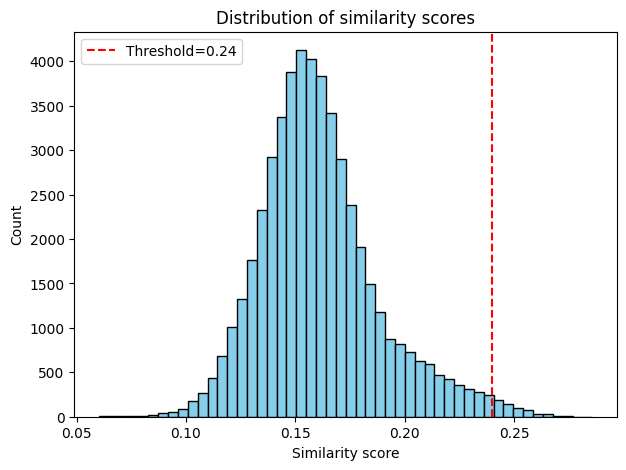

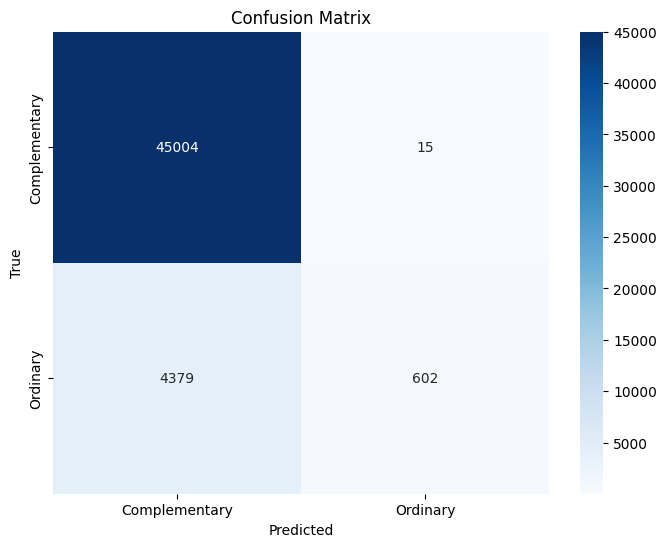

: 

In [ ]:
Visualization.plot_distribution(scores, threshold=threshold)
Visualization.plot_confusion_matrix(metrics["confusion_matrix"], ["Complementary", "Ordinary"])